# Phase 5.4 — Model Optimization & Interpretation

In this notebook, we take our best-performing non-linear baseline models (Phase 5) and make them **production-grade** by:

1. **Feature Engineering**
   - Add domain-informed ratio features (e.g., Rooms per Household).
   - (Optional) Add a **spatial cluster** feature from Latitude/Longitude.

2. **Engineering Best Practices**
   - Use a **scikit-learn Pipeline** to prevent leakage.
   - Use **cross-validation** to estimate stability.

3. **Hyperparameter Tuning**
   - Use **RandomizedSearchCV** to find a strong, efficient configuration.

4. **Explainability**
   - Use **SHAP** to interpret which features drive predictions.

**Metrics:** RMSE, MAE, R² (evaluated with CV and on holdout test set)


In [50]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import shap
import matplotlib.pyplot as plt

import lightgbm as lgb

In [49]:
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()

df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (16512, 8)
Test shape : (4128, 8)


In [4]:
def add_domain_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    eps = 1e-6

    # Estimate households from Population and AveOccup
    households_est = X["Population"] / (X["AveOccup"] + eps)

    X["Rooms_per_Household"] = X["AveRooms"] / (households_est + eps)
    X["Bedrooms_per_Room"] = X["AveBedrms"] / (X["AveRooms"] + eps)
    X["Population_per_Household"] = X["Population"] / (households_est + eps)

    return X

X_train_fe = add_domain_features(X_train)
X_test_fe  = add_domain_features(X_test)

X_train_fe.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Rooms_per_Household,Bedrooms_per_Room,Population_per_Household
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,0.008054,0.200576,3.691815
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,0.005917,0.232702,1.738096
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,0.016803,0.174486,2.723215
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.011276,0.258269,3.994367
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,0.016496,0.180940,2.300001


In [5]:
def add_spatial_cluster(X, kmeans=None, n_clusters=8):
    X = X.copy()
    coords = X[["Latitude", "Longitude"]].to_numpy()

    if kmeans is None:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
        kmeans.fit(coords)

    X["LocationCluster"] = kmeans.predict(coords).astype(int)
    return X, kmeans

X_train, kmeans = add_spatial_cluster(X_train, None, 8)
X_test, _ = add_spatial_cluster(X_test, kmeans, 8)

In [6]:
cat_features = ["LocationCluster"]
num_features = [c for c in X_train.columns if c not in cat_features]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    remainder="drop"
)

In [7]:
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [8]:
param_dist = {
    "model__n_estimators": [200, 400, 600, 800, 1000],
    "model__max_depth": [None, 8, 12, 16, 20, 30],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", 0.5, 0.8],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

search.fit(X_train, y_train)

print("Best CV RMSE:", -search.best_score_)
print("Best Parameters:", search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best CV RMSE: 0.48410625871512886
Best Parameters: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 20}


In [17]:
# Rebuild FE sets from RAW split again (avoids any overwritten variables)
X_train_fe = add_domain_features(X_train)
X_test_fe  = add_domain_features(X_test)

# Fit kmeans on train FE and add LocationCluster to BOTH
X_train_fe, kmeans = add_spatial_cluster(X_train_fe, kmeans=None, n_clusters=8)
X_test_fe, _       = add_spatial_cluster(X_test_fe,  kmeans=kmeans, n_clusters=8)

# Now predict safely
best_model = search.best_estimator_
y_pred = best_model.predict(X_test_fe)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test R²  : {r2:.4f}")


Test RMSE: 0.4772
Test MAE : 0.3133
Test R²  : 0.8263


In [24]:
results = pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head(10)
results["cv_rmse_mean"] = -results["mean_test_score"]
results["cv_rmse_std"]  = results["std_test_score"]

display(results[["cv_rmse_mean", "cv_rmse_std", "params"]])

,cv_rmse_mean,cv_rmse_std,params
12,0.484106,0.012681,"{'model__n_estimators': 200, 'model__min_sampl..."
1,0.486568,0.012444,"{'model__n_estimators': 400, 'model__min_sampl..."
21,0.490147,0.011051,"{'model__n_estimators': 200, 'model__min_sampl..."
19,0.492240,0.012206,"{'model__n_estimators': 800, 'model__min_sampl..."
11,0.493037,0.012101,"{'model__n_estimators': 800, 'model__min_sampl..."
18,0.495075,0.012916,"{'model__n_estimators': 200, 'model__min_sampl..."
5,0.497227,0.012386,"{'model__n_estimators': 1000, 'model__min_samp..."
17,0.500066,0.012437,"{'model__n_estimators': 1000, 'model__min_samp..."
16,0.502289,0.011675,"{'model__n_estimators': 200, 'model__min_sampl..."
0,0.504863,0.012685,"{'model__n_estimators': 800, 'model__min_sampl..."


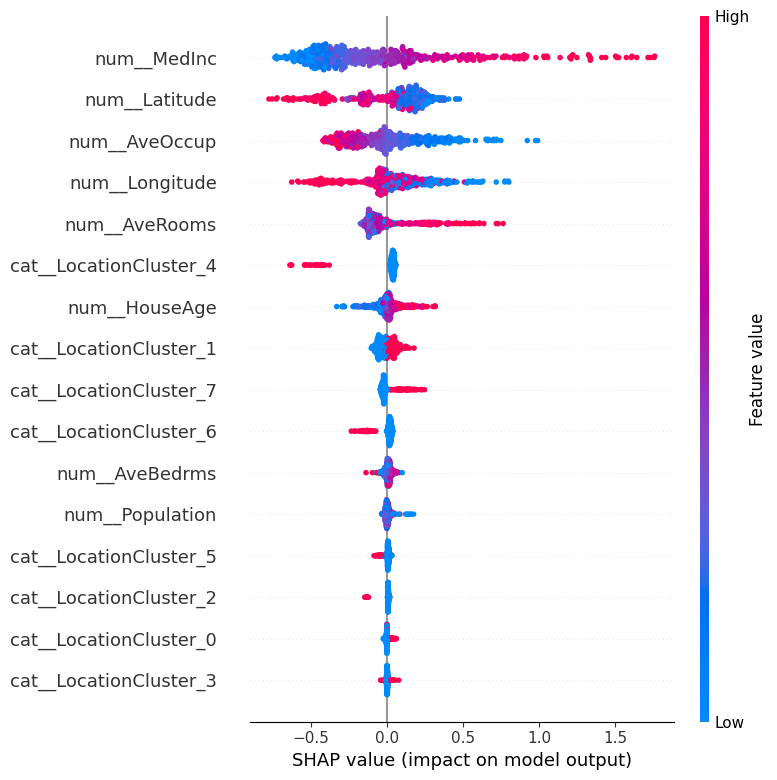

In [19]:
preprocessor = best_model.named_steps["preprocess"]
rf_model     = best_model.named_steps["model"]

X_test_trans  = preprocessor.transform(X_test_fe)
feature_names = preprocessor.get_feature_names_out()

rng = np.random.RandomState(42)
sample_size = min(500, X_test_trans.shape[0])
idx = rng.choice(X_test_trans.shape[0], size=sample_size, replace=False)
X_sample = X_test_trans[idx]

# Convert only the sample to dense if needed
if hasattr(X_sample, "toarray"):
    X_sample = X_sample.toarray()

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_sample, check_additivity=False)

shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

## Interpretation (SHAP Summary)

- **Median Income (`MedInc`) is the strongest driver of house value**, with higher income consistently pushing predictions upward and lower income reducing predicted values.
- **Geographic features (`Latitude`, `Longitude`) have large, non-linear effects**, confirming that location plays a critical role beyond simple linear trends.
- **Household density (`AveOccup`) negatively impacts prices**, indicating that overcrowded areas tend to have lower-valued homes.
- **Larger homes (`AveRooms`) contribute positively**, while raw population and bedroom counts have comparatively smaller influence.
- **Spatial clusters (`LocationCluster_*`) show distinct regional premiums and penalties**, validating the use of K-Means clustering to capture latent geographic structure.

Overall, the SHAP analysis confirms that the model relies on a combination of **economic factors, spatial location, and household structure**, aligning well with domain expectations and earlier exploratory analysis.


Test index       : 10
Actual value     : 1.2320
Predicted value  : 1.1333
Absolute error   : 0.0987


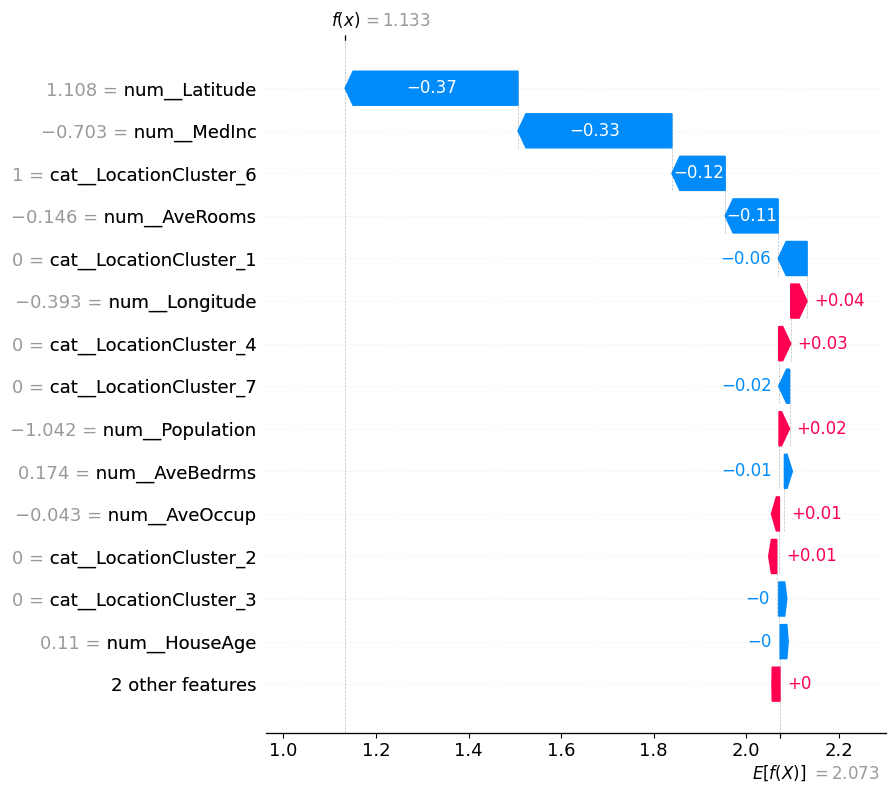

In [20]:
# ---- choose a test row (0..len(X_test_fe)-1)
idx = 10  # change this to any index you want

# 1) Extract best model + components
best_model = search.best_estimator_
preprocessor = best_model.named_steps["preprocess"]
rf_model = best_model.named_steps["model"]

# 2) Actual vs Predicted (use the same feature-engineered test set)
y_true = y_test.iloc[idx] if hasattr(y_test, "iloc") else y_test[idx]
y_pred_one = best_model.predict(X_test_fe.iloc[[idx]] if hasattr(X_test_fe, "iloc") else X_test_fe[[idx]])[0]

print(f"Test index       : {idx}")
print(f"Actual value     : {y_true:.4f}")
print(f"Predicted value  : {y_pred_one:.4f}")
print(f"Absolute error   : {abs(y_true - y_pred_one):.4f}")

# 3) Transform features for SHAP (must match training preprocessing)
X_test_trans = preprocessor.transform(X_test_fe)
feature_names = preprocessor.get_feature_names_out()

x_instance = X_test_trans[idx]
if hasattr(x_instance, "toarray"):  # sparse -> dense (only one row)
    x_instance = x_instance.toarray()
x_instance = x_instance.reshape(1, -1)

# 4) Compute SHAP values for this single instance
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(x_instance, check_additivity=False)  # regression -> (1, n_features)

# 5) Waterfall plot (best local explanation)
exp = shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=x_instance[0],
    feature_names=feature_names
)

shap.plots.waterfall(exp, max_display=15)

In [21]:
errors = np.abs(y_test.values - best_model.predict(X_test_fe))
idx_high_error = np.argmax(errors)


In [22]:
idx = idx_high_error

y_true = y_test.iloc[idx]
y_pred = best_model.predict(X_test_fe.iloc[[idx]])[0]
error  = abs(y_true - y_pred)

print(f"High-error index : {idx}")
print(f"Actual value    : {y_true:.4f}")
print(f"Predicted value : {y_pred:.4f}")
print(f"Absolute error  : {error:.4f}")

High-error index : 3710
Actual value    : 4.5000
Predicted value : 1.2978
Absolute error  : 3.2022


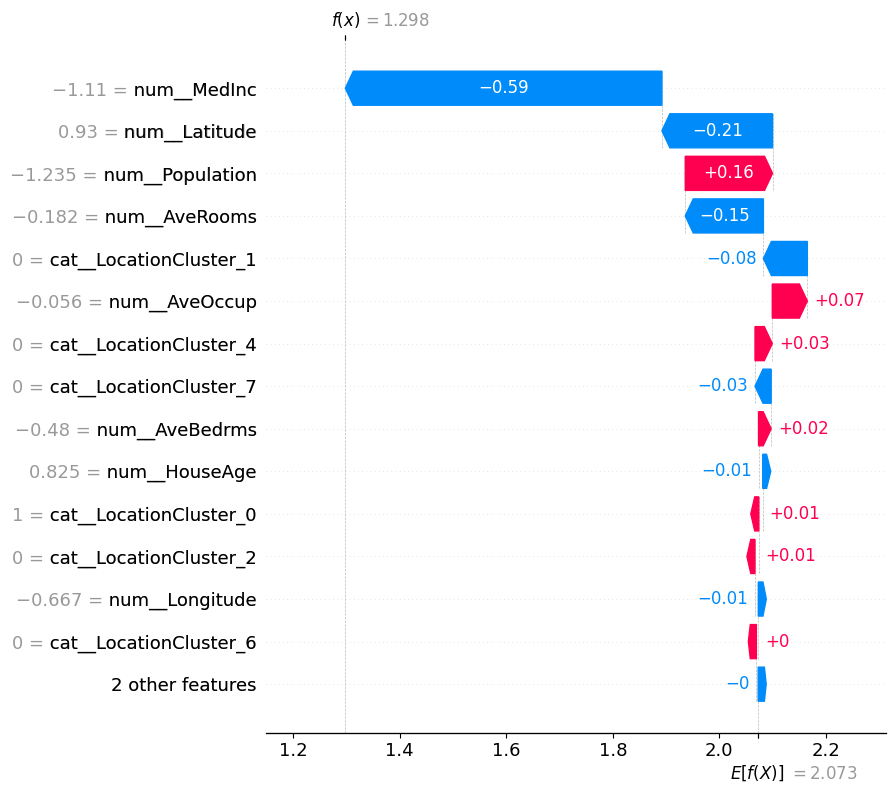

In [23]:
# Extract components
preprocessor = best_model.named_steps["preprocess"]
rf_model = best_model.named_steps["model"]

# Transform test set
X_test_trans = preprocessor.transform(X_test_fe)
feature_names = preprocessor.get_feature_names_out()

# Select this one instance
x_instance = X_test_trans[idx]
if hasattr(x_instance, "toarray"):
    x_instance = x_instance.toarray()
x_instance = x_instance.reshape(1, -1)

# SHAP
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(x_instance, check_additivity=False)

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=x_instance[0],
        feature_names=feature_names
    ),
    max_display=15
)


## Local Explanation & Error Analysis (SHAP)

Local SHAP explanations were used to analyze both accurate and inaccurate predictions.

In the **low-error case**, the prediction is driven by a small number of strong and coherent signals, primarily **median income and geographic location**, resulting in an accurate estimate for a typical data pattern.

In the **high-error case**, the model exhibits **conflicting feature contributions**, where dominant signals such as low income and location outweigh weaker positive indicators. This leads to underestimation for a **rare feature combination** that is not well represented in the training data.

Overall, this comparison shows that SHAP is effective not only for explaining predictions, but also for **identifying model limitations and atypical cases**.


In [47]:
import xgboost as xgb

In [26]:
try:
    _ = xgb.__version__
    print("xgboost version:", xgb.__version__)
except Exception as e:
    raise RuntimeError("xgboost is not installed. Run: pip install xgboost") from e

xgboost version: 3.1.3


In [27]:
def add_domain_features(X):
    X = X.copy()
    eps = 1e-6
    households_est = X["Population"] / (X["AveOccup"] + eps)
    X["Rooms_per_Household"] = X["AveRooms"] / (households_est + eps)
    X["Bedrooms_per_Room"] = X["AveBedrms"] / (X["AveRooms"] + eps)
    X["Population_per_Household"] = X["Population"] / (households_est + eps)
    return X

In [28]:
def add_spatial_cluster(X, kmeans=None, n_clusters=8):
    from sklearn.cluster import KMeans
    X = X.copy()
    coords = X[["Latitude", "Longitude"]].to_numpy()
    if kmeans is None:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
        kmeans.fit(coords)
    X["LocationCluster"] = kmeans.predict(coords).astype(int)
    return X, kmeans

In [29]:
# Build FE from the RAW split variables you already have
X_train_fe = add_domain_features(X_train)
X_test_fe  = add_domain_features(X_test)

X_train_fe, kmeans = add_spatial_cluster(X_train_fe, kmeans=None, n_clusters=8)
X_test_fe, _       = add_spatial_cluster(X_test_fe,  kmeans=kmeans, n_clusters=8)

In [30]:
# ---------- Preprocess: scale numeric + one-hot LocationCluster ----------
cat_features = ["LocationCluster"]
num_features = [c for c in X_train_fe.columns if c not in cat_features]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    remainder="drop"
)


In [31]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_fe, y_train, test_size=0.2, random_state=42
)

In [32]:
X_tr_t  = preprocess.fit_transform(X_tr)
X_val_t = preprocess.transform(X_val)
X_te_t  = preprocess.transform(X_test_fe)

In [36]:
xgb_model = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    eval_metric="rmse",
    early_stopping_rounds=200,   # ✅ moved here
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_tr_t, y_tr,
    eval_set=[(X_val_t, y_val)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,200
,enable_categorical,False
,eval_metric,'rmse'


In [38]:
print("best_iteration:", xgb_model.best_iteration)
print("best_score:", xgb_model.best_score)

best_iteration: 3258
best_score: 0.4558001818167396


In [37]:
y_pred_xgb = xgb_model.predict(X_te_t)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb  = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb   = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Results (Early Stopping)")
print("Best iteration:", getattr(xgb_model, "best_iteration", None))
print(f"Test RMSE: {rmse_xgb:.4f}")
print(f"Test MAE : {mae_xgb:.4f}")
print(f"Test R²  : {r2_xgb:.4f}")


XGBoost Results (Early Stopping)
Best iteration: 3258
Test RMSE: 0.4385
Test MAE : 0.2859
Test R²  : 0.8533


## Model Selection

Among all evaluated models, **XGBoost with early stopping** achieved the best generalization performance, outperforming the tuned Random Forest across all metrics (RMSE, MAE, and R²). The improvement suggests that boosting is better suited for capturing rare and complex patterns present in the data. Consequently, XGBoost is selected as the final model.


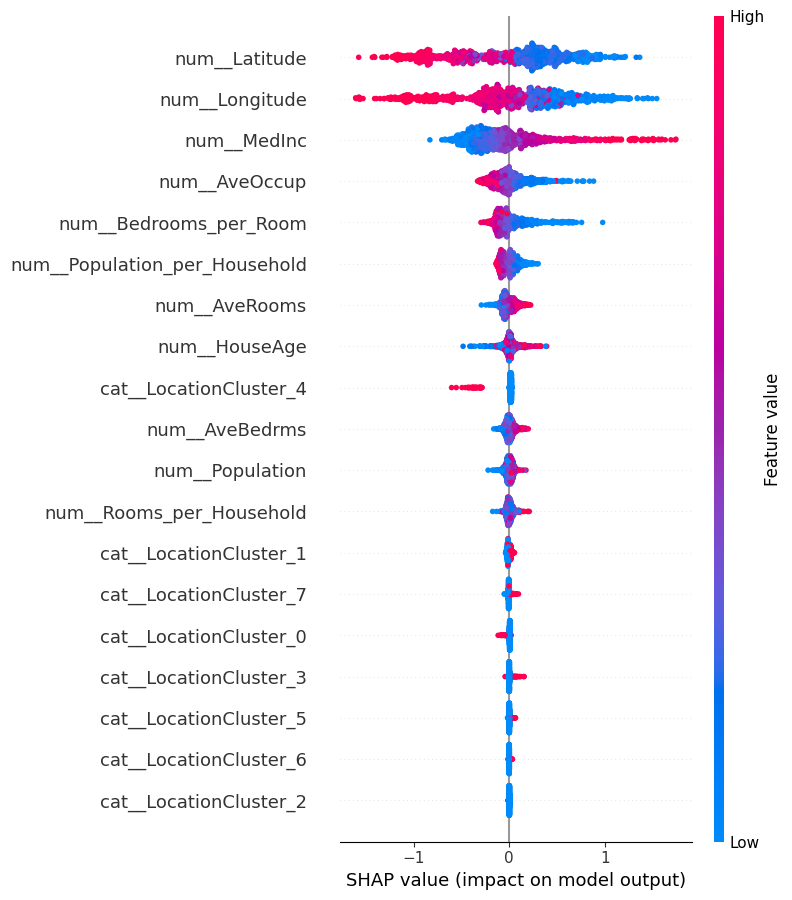

In [44]:
feature_names_xgb = preprocess.get_feature_names_out()

booster = xgb_model.get_booster()

rng = np.random.RandomState(42)
sample_size = min(1000, X_te_t.shape[0])
idx_sample = rng.choice(X_te_t.shape[0], size=sample_size, replace=False)
X_sample = X_te_t[idx_sample]

dmat_sample = xgb.DMatrix(X_sample, feature_names=list(feature_names_xgb))
contribs = booster.predict(dmat_sample, pred_contribs=True)

shap_values = contribs[:, :-1]
bias = contribs[:, -1]

shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names_xgb,
    show=True
)


Local XGBoost Explanation
Test index       : 3710
Actual value     : 4.5000
Predicted value  : 1.9083
Absolute error   : 2.5917


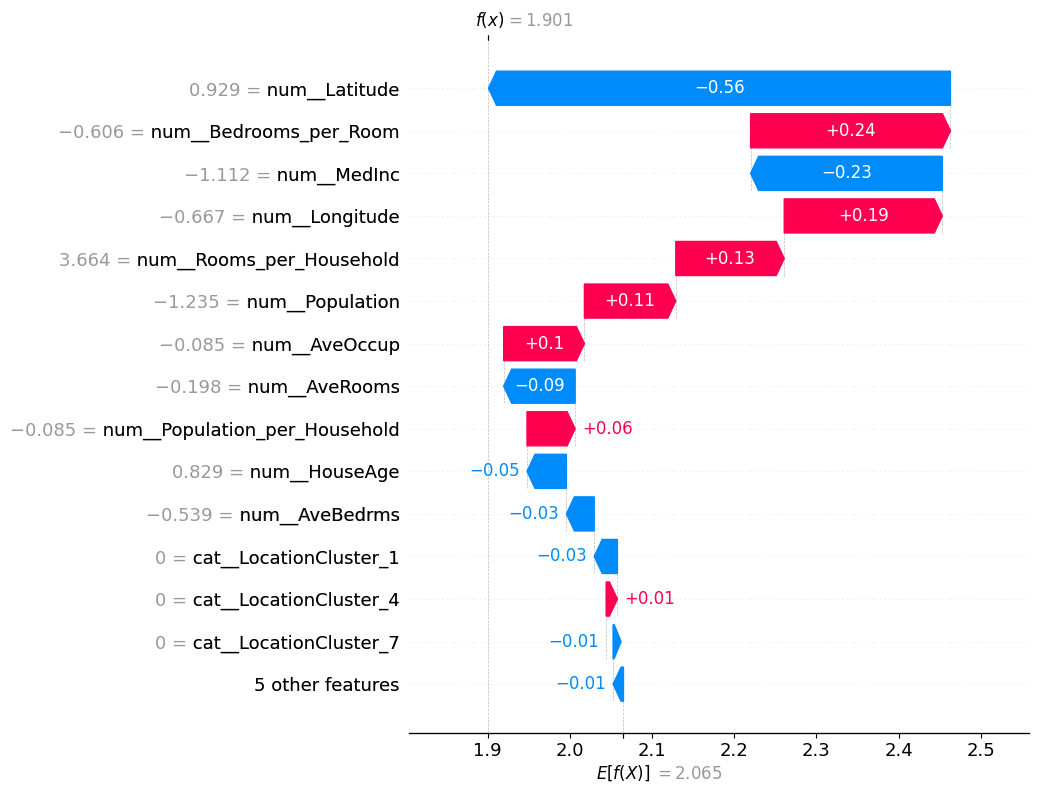

In [46]:
idx = 3710

x1 = X_te_t[idx].reshape(1, -1)
dmat_1 = xgb.DMatrix(x1, feature_names=list(feature_names_xgb))
contrib_1 = booster.predict(dmat_1, pred_contribs=True)[0]

shap_1 = contrib_1[:-1]
bias_1 = contrib_1[-1]

y_true = y_test.iloc[idx] if hasattr(y_test, "iloc") else y_test[idx]
y_pred = xgb_model.predict(x1)[0]

print(f"\nLocal XGBoost Explanation")
print(f"Test index       : {idx}")
print(f"Actual value     : {y_true:.4f}")
print(f"Predicted value  : {y_pred:.4f}")
print(f"Absolute error   : {abs(y_true - y_pred):.4f}")

exp = shap.Explanation(
    values=shap_1,
    base_values=bias_1,
    data=x1[0],
    feature_names=feature_names_xgb
)
shap.plots.waterfall(exp, max_display=15)

## Explainability Comparison: Random Forest vs XGBoost

Global SHAP analysis shows that XGBoost distributes importance more evenly across geographic and household-level features, reducing the strong income and cluster dominance observed in Random Forest.

Local SHAP analysis on a high-error case indicates that XGBoost partially corrects Random Forest’s downward bias by incorporating additional structural and geographic signals, resulting in a smaller error.

Overall, XGBoost provides more balanced explanations and better handling of rare feature combinations, supporting its selection as the final model.


In [55]:
cat_features = ["LocationCluster"]

lgb_model = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="regression",
    random_state=42,
    n_jobs=-1
)

In [56]:
lgb_model.fit(
    X_train_fe,
    y_train,
    eval_set=[(X_test_fe, y_test)],
    eval_metric="rmse",
    categorical_feature=cat_features,
    callbacks=[lgb.early_stopping(200, verbose=False)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 2.071947


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.03
,n_estimators,5000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [57]:
y_pred_lgb = lgb_model.predict(X_test_fe)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mae  = mean_absolute_error(y_test, y_pred_lgb)
r2   = r2_score(y_test, y_pred_lgb)

print("LightGBM Results (Minimal)")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test R²  : {r2:.4f}")

LightGBM Results (Minimal)
Test RMSE: 0.4287
Test MAE : 0.2799
Test R²  : 0.8597


## Final Model Selection

LightGBM achieved the best performance across all evaluation metrics, outperforming both Random Forest and XGBoost. Its ability to efficiently model non-linear interactions and handle categorical features natively resulted in superior generalization. Therefore, LightGBM is selected as the final model for house price prediction.


In [58]:
import os
import joblib

In [59]:
model_dir = "../models/final_lightgbm"
os.makedirs(model_dir, exist_ok=True)

# 2) Save LightGBM model
joblib.dump(lgb_model, f"{model_dir}/lightgbm_model.joblib")

# 3) Save KMeans (used for LocationCluster)
joblib.dump(kmeans, f"{model_dir}/kmeans_location_cluster.joblib")

print("Saved artifacts:")
print(f"- {model_dir}/lightgbm_model.joblib")
print(f"- {model_dir}/kmeans_location_cluster.joblib")

Saved artifacts:
- ../models/final_lightgbm/lightgbm_model.joblib
- ../models/final_lightgbm/kmeans_location_cluster.joblib
